In [1]:
#James Alfano
import pandas as pd
import datasets
import sys  
import contractions
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

#Run these commands when running for first time
#nltk.download('punkt')
#nltk.download('stopwords')
#!{sys.executable} -m pip install contractions

In [2]:
## load the full dataset of 300k articles
dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')

Found cached dataset cnn_dailymail (/Users/jamesalfano/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)
100%|██████████| 3/3 [00:00<00:00, 37.11it/s]


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [4]:
#Read in Training
lst_dics = [dic for dic in dataset["train"]]
train = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y"})[["text","y"]]
train.head(5)

,text,y
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."


In [5]:
#Read in testing
lst_dics = [dic for dic in dataset["test"]]
test = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y"})[["text","y"]]
test.head()

,text,y
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b..."
2,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...
3,(CNN)Five Americans who were monitored for thr...,17 Americans were exposed to the Ebola virus w...
4,(CNN)A Duke student has admitted to hanging a ...,Student is no longer on Duke University campus...


In [6]:
#Read in Validation
lst_dics = [dic for dic in dataset["validation"]]
validation = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y"})[["text","y"]]
validation.head()

,text,y
0,"(CNN)Share, and your gift will be multiplied. ...",Zully Broussard decided to give a kidney to a ...
1,"(CNN)On the 6th of April 1996, San Jose Clash ...",The 20th MLS season begins this weekend .\nLea...
2,"(CNN)French striker Bafetimbi Gomis, who has a...",Bafetimbi Gomis collapses within 10 minutes of...
3,(CNN)It was an act of frustration perhaps more...,Rory McIlroy throws club into water at WGC Cad...
4,(CNN)A Pennsylvania community is pulling toget...,"Cayman Naib, 13, hasn't been heard from since ..."


In [7]:
print(train.shape)
print(test.shape)
print(validation.shape)


(287113, 2)
(11490, 2)
(13368, 2)


In [8]:
print(train.iloc[0,0])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

In [9]:
print(train.iloc[0,1])

Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .


## Preprocessing 

In [5]:
#take a subset of the training data
subset = train.iloc[0:50,0:50]
subset.shape
subset.head()

,text,y
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."


In [6]:
#Function to plot word frequencies 
def wrd_freq_plot(df,title):
    # use explode to expand the lists into separate rows
    dfe = df.text.explode().to_frame().reset_index(drop=True)
    # groupby the values in the column, get the count and sort
    dfg = dfe.groupby('text').text.count() \
                                .reset_index(name='count') \
                                .sort_values(['count'], ascending=False) \
                                .head(20).reset_index(drop=True)
    dfg.plot.bar(x='text')
    plt.title(title)

In [7]:
#Each article begins with a location, source, and --
#e.g. "MINNEAPOLIS, Minnesota (CNN) --" or "WASHINGTON (CNN) --"
#This function seeks to remove the intro
def rvm_article_intro(df):
    for i in range(len(df)):
        df.iloc[i,0] = df.iloc[i,0][df.iloc[i,0].find('-')+3:] #+3 to remove the "-- " 

In [8]:
#Expand contractions 
#e.g. they're -> they are
def expand_contractions(df):
    for i in range(len(df)):
        df.iloc[i,0] = contractions.fix(df.iloc[i,0])
        df.iloc[i,1] = contractions.fix(df.iloc[i,1])

In [9]:
#Lower Case Function
def lower_case_text(df):
    df["text"] = df["text"].str.lower()
    df["y"] = df["y"].str.lower()

In [10]:
#Function to tokenize df 
def token(df):
    for i in range(len(df)):
        df.iloc[i,0] = nltk.word_tokenize(df.iloc[i,0])
        df.iloc[i,1] = nltk.word_tokenize(df.iloc[i,1])

In [11]:
#Removing stop words/punctuation
#e.g. 'a', 'an', 'not', 'do', 'over', 'themselves', "--", "''", ":", and "."
def rmv_stop_wrds(df):
    stop_words = set(stopwords.words('english'))
    char_rmv = ["'",",","``","`","-", "--","''",":",".","'s"]
    stop_words.update(char_rmv) #Adding extra stopwords
    for i in range(len(df)):
        df.iloc[i,0] = [w for w in df.iloc[i,0] if not w in stop_words] 
        df.iloc[i,1] = [w for w in df.iloc[i,1] if not w in stop_words] 

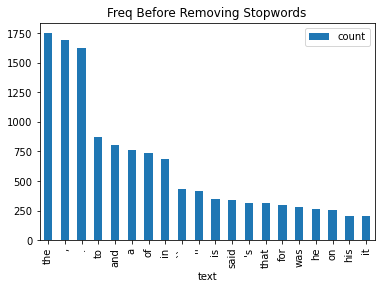

In [12]:
#Plot word Freq before removing stopwords 
expand_contractions(subset)
lower_case_text(subset)
rvm_article_intro(subset)
token(subset)
wrd_freq_plot(subset,"Freq Before Removing Stopwords")

In [13]:
subset.head()

,text,y
0,"[harry, potter, star, daniel, radcliffe, gains...","[harry, potter, star, daniel, radcliffe, gets,..."
1,"[the, ninth, floor, of, the, miami-dade, pretr...","[mentally, ill, inmates, in, miami, are, house..."
2,"[drivers, who, were, on, the, minneapolis, bri...","[new, :, ``, i, thought, i, was, going, to, di..."
3,"[doctors, removed, five, small, polyps, from, ...","[five, small, polyps, found, during, procedure..."
4,"[the, national, football, league, has, indefin...","[new, :, nfl, chief, ,, atlanta, falcons, owne..."


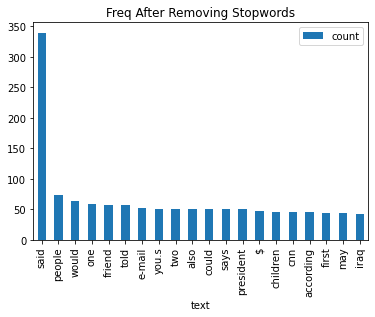

In [14]:
#Plot word Freq after removing stopwords
rmv_stop_wrds(subset)
wrd_freq_plot(subset,"Freq After Removing Stopwords")

In [15]:
subset.head()

,text,y
0,"[harry, potter, star, daniel, radcliffe, gains...","[harry, potter, star, daniel, radcliffe, gets,..."
1,"[ninth, floor, miami-dade, pretrial, detention...","[mentally, ill, inmates, miami, housed, forgot..."
2,"[drivers, minneapolis, bridge, collapsed, told...","[new, thought, going, die, driver, says, man, ..."
3,"[doctors, removed, five, small, polyps, presid...","[five, small, polyps, found, procedure, ;, non..."
4,"[national, football, league, indefinitely, sus...","[new, nfl, chief, atlanta, falcons, owner, cri..."


In [16]:
print(subset.iloc[0,1])

['harry', 'potter', 'star', 'daniel', 'radcliffe', 'gets', '£20m', 'fortune', 'turns', '18', 'monday', 'young', 'actor', 'says', 'plans', 'fritter', 'cash', 'away', 'radcliffe', "'s", 'earnings', 'first', 'five', 'potter', 'films', 'held', 'trust', 'fund']


In [17]:
print(subset.iloc[0,0])

['harry', 'potter', 'star', 'daniel', 'radcliffe', 'gains', 'access', 'reported', '£20', 'million', '(', '$', '41.1', 'million', ')', 'fortune', 'turns', '18', 'monday', 'insists', 'money', 'cast', 'spell', 'daniel', 'radcliffe', 'harry', 'potter', 'harry', 'potter', 'order', 'phoenix', 'disappointment', 'gossip', 'columnists', 'around', 'world', 'young', 'actor', 'says', 'plans', 'fritter', 'cash', 'away', 'fast', 'cars', 'drink', 'celebrity', 'parties', 'plan', 'one', 'people', 'soon', 'turn', '18', 'suddenly', 'buy', 'massive', 'sports', 'car', 'collection', 'something', 'similar', 'told', 'australian', 'interviewer', 'earlier', 'month', 'think', 'particularly', 'extravagant', 'things', 'like', 'buying', 'things', 'cost', '10', 'pounds', 'books', 'cds', 'dvds', '18', 'radcliffe', 'able', 'gamble', 'casino', 'buy', 'drink', 'pub', 'see', 'horror', 'film', 'hostel', 'part', 'ii', 'currently', 'six', 'places', 'number', 'one', 'movie', 'uk', 'box', 'office', 'chart', 'details', 'mark',